In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
raw_df = pd.read_excel('Official FI Survey Raw Data Lightly Cleaned.xlsx')
raw_df = raw_df.drop('Index', axis = 1)

In [106]:
pd.set_option('display.max_columns', None)
raw_df.head()

,Gender,Age,Household income contributors,Relationship Status,Finances combined,Plan to have children,Number of intended children,Number dependents,FI,Year FI,Occupation,Unnamed: 12,Housing situation,Unnamed: 14,Have roommates,Country,Living environment,Unnamed: 18,COL index,Commute length,Citezenships,Highest Education,American Indian or Alaskan Native?,Asian or Pacific Islander?,Black or African American?,Hispanic or Latino?,White / Caucasian?,Prefer not to answer?,Caribbean?,Military - Active Duty or Veteran?,LGBTQ?,Learning disability?,Physical disability?,Mental illness?,Addiction?,Survivor of Abuse,Gross household annual wage income,Gross household annual side gig income,Gross household annual real estate income,Gross household annual investment income,Gross household annual other income,Household student debt,Student debt maturity,Student debt IR,Household credit card debt,Credit card debt maturity,Credit card IR,Household auto loan debt,Auto loan debt maturity,Auto loan IR,Household mortgage debt,Mortgage debt maturity,Mortgage debt IR,Household other debt,Other debt maturity,Other debt IR,NW excluding real estate,Value of primary residence,What did you do with windfall?,Unnamed: 60,Household annual expenditures on the following?,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Savings rate,Consider yourself FI number,Unnamed: 79,Percentage FI,When you reach FI...,Unnamed: 82,SWR,Projected real annual growth,Continue working full-time,Work part-time,Not work,Volunteer,Create new business,Continue my existing side gig?,N/A?,Unsure?,Continue working full-time.1,Work part-time.1,Not work.1,Volunteer.1,Create new business.1,Continue my existing side gig?.1,N/A?.1,Unsure?.1,What are your estate planning intentions?,Unnamed: 102,Unnamed: 103,How frequently do you check your balances?,Plan to move when FIRE,Childhood financial stability,Parent financial status,Parents taught about money,Age of financial literacy,Age learned about FIRE,NW when started toward FIRE,Assets when started toward FIRE,Debts when started toward FIRE,Consent of response release
0,Male,26,1,"In a relationship, but not married",Yes,Plan Children,2.0,NaN,No,NaN,"Licensed Professional (Attorney, Accountant, E...",NaN,Rent,NaN,No,United States of America,Suburban,NaN,"81-100 (San Jose, CA US; Portland OR US; Dubli...",30-60 minutes,United States,"College graduate, Bachelor's Degree",NaN,NaN,NaN,NaN,White / Caucasian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110000.0,0.0,0.0,750.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35000.0,0.0,NaN,NaN,19600.0,NaN,2000.0,NaN,NaN,500.0,1500.0,NaN,3000.0,1000.0,NaN,2000.0,1000.0,NaN,500.0,500.0,20.0,1500000,2500000,2.0,25.0,51,4.0,3.0,NaN,Work part-time,NaN,Volunteer,NaN,NaN,NaN,NaN,Continue working full-time,NaN,NaN,Volunteer,NaN,NaN,NaN,NaN,Leave inheritance for family,NaN,NaN,Weekly,"Yes, within my country",Mostly Stable,Middle Class,"No, we did not talk about it",15.0,18.0,20000.0,25000.0,0.0,Yes
1,Male,37,2,"In a relationship, but not married",Yes,Have Children,2.0,0.0,No,NaN,Legal Occupations,NaN,Own,NaN,No,Sweden,Suburban,NaN,"81-100 (San Jose, CA US; Portland OR US; Dubli...",30-60 minutes,NaN,Graduate degree,NaN,NaN,NaN,NaN,White / Caucasian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280000.0,0.0,0.0,0.0,0.0,30000.0,3000.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,244000.0,15000.0,0.7,0.0,0.0,0.0,9000.0,450000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45,55,10.0,NaN,45,4.0,NaN,NaN,Work part-time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Work part-time,NaN,NaN,NaN,NaN,NaN,NaN,Leave inheritance for family,NaN,NaN,Daily,No,Somewhat Unstable,Middle Class,"No, they were not financially savvy",30.0,30.0,NaN,NaN,NaN,Yes
2,Male,20,1,"Single, never married",NaN,Undecided,NaN,0.0,No,NaN,Computer and Mathematical Occupations - Softwa...,NaN,Rent,NaN,Yes,United States of America

Looking at the survey answers, it's apparent that in some cases, each response choice is its own column. 

In [107]:
# number of responses
len(raw_df)

1378

First, we need to get these column names under control

In [108]:
#pd.set_option('display.max_columns', None)
raw_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 114 columns):
Gender                                             1378 non-null object
Age                                                1378 non-null int64
Household income contributors                      1378 non-null int64
Relationship Status                                1378 non-null object
Finances combined                                  951 non-null object
Plan to have children                              1376 non-null object
Number of intended children                        752 non-null float64
Number dependents                                  637 non-null float64
FI                                                 1378 non-null object
Year FI                                            46 non-null float64
Occupation                                         1374 non-null object
Unnamed: 12                                        86 non-null object
Housing situation                 

In [109]:
# see whether Unnamed 12 is worth keeping

raw_df['Unnamed: 12'].loc[~raw_df['Unnamed: 12'].isnull()]

14                        Actuary
44                Pharmaceuticals
50                   Grad student
66                Medical Student
71                       Military
                  ...            
1313         Corrections officer 
1318                     Military
1325       Firefighter/Paramedic 
1335    Environmental Management 
1349                     Military
Name: Unnamed: 12, Length: 86, dtype: object

There are 86 values, and a lot of them are similar to each other. We'll try to consolidate and keep what we can

In [110]:
raw_df['Unnamed: 12'].unique()

array([nan, 'Actuary', 'Pharmaceuticals', 'Grad student',
       'Medical Student', 'Military', 'Marketing/eCommerce',
       'Financial data science', 'Student', 'Consulting',
       'Dental Student', 'Technical business analyst consultant',
       'Retail - grocery, assistant management', 'business owner ',
       'Active duty U.S. Navy', 'Energy industry management', 'Banking',
       'Strategy Consulting', 'Marketing company owner ', 'IT Auditor',
       'IT Risk Management', 'Power Plant Operations', 'Finance',
       'Military Officer', 'Government - Urban Planner',
       'Military - USAF Student Pilot', 'Non-life actuary ',
       'Energy Analyst / Consultant', 'Government',
       'Conscript in the armed forces', 'Fighter Pilot',
       'Aviation industry', 'US Army', 'student - electrical engineering',
       'Firefighter/Paramedic', 'Audit/program management',
       'Engineering Student', 'Program management', 'Telecommunications',
       'Fvhxdxxxxrf²¢,#¢', 'Retail', 'Self

In [111]:
military_gov = ['Military', 'Active duty U.S. Navy', 'Military Officer', 'Government - Urban Planner', 
                'Military - USAF Student Pilot', 'Government', 'Fighter Pilot', 'US Army', 'Firefighter/Paramedic',
               'Politics/government', 'military', 'Corrections officer ', 'Firefighter/Paramedic ']
student = ['Grad student', 'Medical Student', 'Student', 'Dental Student', 'student - electrical engineering',
              'Engineering Student', 'Graduate Student (Engineering)', ]
science_research = ['Pharmaceuticals', 'Clinical Research', 'Industrial/Organizational Psychologist', 'research',
                   'Chemical research', 'Chemical  engineer']

def occupation(x):
    if x in military_gov:
        x = 'Military/Gov'
    elif x in student:
        x = 'Student'
    elif x in science_research:
        x = 'Science/Research'
    else:
        x = 'Other'
    return x

raw_df['Unnamed: 12'] = raw_df['Unnamed: 12'].apply(occupation)

In [112]:
raw_df['Unnamed: 12'].unique()

array(['Other', 'Science/Research', 'Student', 'Military/Gov'],
      dtype=object)

In [113]:
# Consolidate occupation responses spread across two columns

raw_df['Occupation'] = np.where(raw_df['Occupation']=='Other (please specify)', raw_df['Unnamed: 12'], raw_df['Occupation'])
raw_df['Housing situation'].loc[raw_df['Housing situation'] == 'Other (please specify)'] = 'Other'

# drop Unnamed: 12
raw_df = raw_df.drop(['Unnamed: 12'], axis =1)

In [114]:
# see whether Unnamed 14 is worth keeping

raw_df['Unnamed: 14'].loc[~raw_df['Unnamed: 14'].isnull()]

130               Fiance owns the house, I pay him rent. 
223     Comped apartment in exchange for community eve...
230                       Live in a house owned by family
248              Cooperative housing (similar to renting)
284                                           Vandwelling
412         Own (wouldn't let me select Own as an option)
502        Live for free at one of my family's properties
566                                      Military Housing
706      Free rent but pay property taxes, utilities, etc
710          Rent primary residence, own rental property 
754     renting during the summer, dorm at school duri...
761                                         House sitting
811     Permanently traveling and living in hotels and...
814     Dorm during school year, anywhere else during ...
836                     Coop, own a share of corporation 
849                                                   van
853                                      Company provided
901     Curren

In [115]:
# Only 14 and there are a variety, so just calling these 'other'
# drop Unnamed: 12
raw_df = raw_df.drop(['Unnamed: 14'], axis =1)

In [116]:
# see whether Unnamed 18 is worth keeping
raw_df['Unnamed: 18'].loc[~raw_df['Unnamed: 18'].isnull()]

98                                             Small town
472                                            Small town
499                                           Albuquerque
528                                            Small town
661          Own condo in urban area and house in suburbs
811     Permanently traveling and living in hotels and...
991                                            Small town
1161                              visiting family+friends
1191                                           Small town
1204                                           Small town
1220                                        Military base
Name: Unnamed: 18, dtype: object

In [117]:
# Add "Small town", "Other" for the rest
raw_df['Living environment'].loc[raw_df['Unnamed: 18']=='Small town'] = 'Small town'
raw_df['Living environment'].loc[raw_df['Living environment']=='Other (please specify)'] = 'Other' 
raw_df = raw_df.drop(['Unnamed: 18'], axis =1)

In [118]:
# Combine the columns for race into one

raw_df['Race'] = np.nan

raw_df['Race'] =raw_df[raw_df.columns[19:26]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

raw_df['Race']

0               White / Caucasian
1               White / Caucasian
2               White / Caucasian
3       Asian or Pacific Islander
4               White / Caucasian
                  ...            
1373            White / Caucasian
1374     White / Caucasian,Jewish
1375            White / Caucasian
1376            White / Caucasian
1377            White / Caucasian
Name: Race, Length: 1378, dtype: object

In [119]:
# drop the obsolete race columns
raw_df.drop(raw_df.columns[19:26], axis=1, inplace=True)

In [120]:
raw_df.head()

,Gender,Age,Household income contributors,Relationship Status,Finances combined,Plan to have children,Number of intended children,Number dependents,FI,Year FI,Occupation,Housing situation,Have roommates,Country,Living environment,COL index,Commute length,Citezenships,Highest Education,Military - Active Duty or Veteran?,LGBTQ?,Learning disability?,Physical disability?,Mental illness?,Addiction?,Survivor of Abuse,Gross household annual wage income,Gross household annual side gig income,Gross household annual real estate income,Gross household annual investment income,Gross household annual other income,Household student debt,Student debt maturity,Student debt IR,Household credit card debt,Credit card debt maturity,Credit card IR,Household auto loan debt,Auto loan debt maturity,Auto loan IR,Household mortgage debt,Mortgage debt maturity,Mortgage debt IR,Household other debt,Other debt maturity,Other debt IR,NW excluding real estate,Value of primary residence,What did you do with windfall?,Unnamed: 60,Household annual expenditures on the following?,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Savings rate,Consider yourself FI number,Unnamed: 79,Percentage FI,When you reach FI...,Unnamed: 82,SWR,Projected real annual growth,Continue working full-time,Work part-time,Not work,Volunteer,Create new business,Continue my existing side gig?,N/A?,Unsure?,Continue working full-time.1,Work part-time.1,Not work.1,Volunteer.1,Create new business.1,Continue my existing side gig?.1,N/A?.1,Unsure?.1,What are your estate planning intentions?,Unnamed: 102,Unnamed: 103,How frequently do you check your balances?,Plan to move when FIRE,Childhood financial stability,Parent financial status,Parents taught about money,Age of financial literacy,Age learned about FIRE,NW when started toward FIRE,Assets when started toward FIRE,Debts when started toward FIRE,Consent of response release,Race
0,Male,26,1,"In a relationship, but not married",Yes,Plan Children,2.0,NaN,No,NaN,"Licensed Professional (Attorney, Accountant, E...",Rent,No,United States of America,Suburban,"81-100 (San Jose, CA US; Portland OR US; Dubli...",30-60 minutes,United States,"College graduate, Bachelor's Degree",NaN,NaN,NaN,NaN,NaN,NaN,NaN,110000.0,0.0,0.0,750.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35000.0,0.0,NaN,NaN,19600.0,NaN,2000.0,NaN,NaN,500.0,1500.0,NaN,3000.0,1000.0,NaN,2000.0,1000.0,NaN,500.0,500.0,20.0,1500000,2500000,2.0,25.0,51,4.0,3.0,NaN,Work part-time,NaN,Volunteer,NaN,NaN,NaN,NaN,Continue working full-time,NaN,NaN,Volunteer,NaN,NaN,NaN,NaN,Leave inheritance for family,NaN,NaN,Weekly,"Yes, within my country",Mostly Stable,Middle Class,"No, we did not talk about it",15.0,18.0,20000.0,25000.0,0.0,Yes,White / Caucasian
1,Male,37,2,"In a relationship, but not married",Yes,Have Children,2.0,0.0,No,NaN,Legal Occupations,Own,No,Sweden,Suburban,"81-100 (San Jose, CA US; Portland OR US; Dubli...",30-60 minutes,NaN,Graduate degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280000.0,0.0,0.0,0.0,0.0,30000.0,3000.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,244000.0,15000.0,0.7,0.0,0.0,0.0,9000.0,450000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45,55,10.0,NaN,45,4.0,NaN,NaN,Work part-time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Work part-time,NaN,NaN,NaN,NaN,NaN,NaN,Leave inheritance for family,NaN,NaN,Daily,No,Somewhat Unstable,Middle Class,"No, they were not financially savvy",30.0,30.0,NaN,NaN,NaN,Yes,White / Caucasian
2,Male,20,1,"Single, never married",NaN,Undecided,NaN,0.0,No,NaN,Computer and Mathematical Occupations - Softwa...,Rent,Yes,United States of America,Suburban,"81-100 (San Jose, CA US; Portland OR US; Dubli...",10-30 minutes,United States,"Some college, no degree",NaN,NaN,NaN,NaN,NaN,NaN,NaN,118000.0,0.0,0.0,0.0,0.0,60000.0,2019.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1100.0,2000.0,0.0,0.

In [121]:
# Combine the various types of income into a "Total Income" field
raw_df['Total Income'] = raw_df.iloc[:,26:31].sum(axis=1) 

raw_df['Total Income']

0       110750.0
1       280000.0
2       118000.0
3       150000.0
4        66200.0
          ...   
1373    105000.0
1374    145000.0
1375    165000.0
1376    106000.0
1377    230000.0
Name: Total Income, Length: 1378, dtype: float64

In [122]:
# Unnamed: 60 is an open field that offers further description--not useful for this analysis

raw_df.drop('Unnamed: 60', inplace=True, axis=1)

In [124]:
# "Household annual expenditures on the following?" and the following columns aren't labeled, so will remove
raw_df.drop(raw_df.columns[49:65], inplace=True, axis=1)

In [128]:
# Rename "Unnamed: 79", remove if less than 100K (not valid number)
raw_df.rename(columns={'Unnamed: 79':'RE Number'}, inplace=True)
raw_df['Consider yourself FI number'] =  raw_df['Consider yourself FI number'].apply(lambda x: x if x > 100000 else np.nan)
raw_df['RE Number'] =  raw_df['RE Number'].apply(lambda x: x if x > 100000 else np.nan)

In [131]:
# Rename columns, valid year dates
raw_df.rename(columns={'When you reach FI...':'Year of Expected FI', 'Unnamed: 82': 'Age of Expected FI'}, inplace=True)
raw_df['Age of Expected FI'].loc[raw_df['Age of Expected FI']=='Old'] = np.nan # removes a non-numeric entry

raw_df['Year of Expected FI'] =  raw_df['Year of Expected FI'].apply(lambda x: x if x > 1950 else np.nan)
raw_df['Age of Expected FI'] =  raw_df['Age of Expected FI'].apply(lambda x: x if x < 100 else np.nan)

In [133]:
raw_df.SWR.unique()

array([4.000000e+00, 3.500000e+00, 5.000000e+00, 3.000000e+00,
       6.400000e+01,          nan, 2.000000e+00, 3.750000e+00,
       2.850000e+00, 4.500000e+00, 5.000000e+01, 7.000000e+00,
       3.333333e+00, 2.500000e+00, 7.500000e+01, 5.000000e-01,
       3.780000e+00, 0.000000e+00, 3.700000e+00, 3.900000e+00,
       3.650000e+00, 7.200000e+00, 3.600000e+00, 3.000000e-02,
       6.000000e+00, 3.300000e-01, 7.000000e-02, 1.000000e+01,
       5.500000e+00, 1.000000e+02, 9.000000e+01, 5.000000e-02,
       4.000000e+01, 4.200000e+00, 6.700000e+00, 4.000000e-02,
       3.300000e+00, 3.800000e+00, 3.333000e+00, 5.500000e-02,
       3.200000e+00, 1.900000e+00, 3.652500e+00, 1.000000e+00,
       6.500000e+01, 6.000000e-01, 2.800000e+00, 3.500000e-02,
       3.250000e+00, 3.330000e+00, 3.850000e+00, 2.220000e+00])

In [138]:
# need to combine estate plan columns into one--will make a list of strings

raw_df['Estate Plan'] =raw_df[raw_df.columns[73:76]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

In [139]:
raw_df.drop(raw_df.columns[73:76], inplace=True, axis=1)

In [140]:
raw_df['Estate Plan'].head()

0             Leave inheritance for family
1             Leave inheritance for family
2                                         
3             Leave inheritance for family
4    Leave inheritance for family,Donation
Name: Estate Plan, dtype: object

In [141]:
raw_df.head()

,Gender,Age,Household income contributors,Relationship Status,Finances combined,Plan to have children,Number of intended children,Number dependents,FI,Year FI,Occupation,Housing situation,Have roommates,Country,Living environment,COL index,Commute length,Citezenships,Highest Education,Military - Active Duty or Veteran?,LGBTQ?,Learning disability?,Physical disability?,Mental illness?,Addiction?,Survivor of Abuse,Gross household annual wage income,Gross household annual side gig income,Gross household annual real estate income,Gross household annual investment income,Gross household annual other income,Household student debt,Student debt maturity,Student debt IR,Household credit card debt,Credit card debt maturity,Credit card IR,Household auto loan debt,Auto loan debt maturity,Auto loan IR,Household mortgage debt,Mortgage debt maturity,Mortgage debt IR,Household other debt,Other debt maturity,Other debt IR,NW excluding real estate,Value of primary residence,What did you do with windfall?,Savings rate,Consider yourself FI number,RE Number,Percentage FI,Year of Expected FI,Age of Expected FI,SWR,Projected real annual growth,Continue working full-time,Work part-time,Not work,Volunteer,Create new business,Continue my existing side gig?,N/A?,Unsure?,Continue working full-time.1,Work part-time.1,Not work.1,Volunteer.1,Create new business.1,Continue my existing side gig?.1,N/A?.1,Unsure?.1,How frequently do you check your balances?,Plan to move when FIRE,Childhood financial stability,Parent financial status,Parents taught about money,Age of financial literacy,Age learned about FIRE,NW when started toward FIRE,Assets when started toward FIRE,Debts when started toward FIRE,Consent of response release,Race,Total Income,Estate Plan
0,Male,26,1,"In a relationship, but not married",Yes,Plan Children,2.0,NaN,No,NaN,"Licensed Professional (Attorney, Accountant, E...",Rent,No,United States of America,Suburban,"81-100 (San Jose, CA US; Portland OR US; Dubli...",30-60 minutes,United States,"College graduate, Bachelor's Degree",NaN,NaN,NaN,NaN,NaN,NaN,NaN,110000.0,0.0,0.0,750.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35000.0,0.0,NaN,20.0,1500000.0,2500000.0,2.0,NaN,51.0,4.0,3.0,NaN,Work part-time,NaN,Volunteer,NaN,NaN,NaN,NaN,Continue working full-time,NaN,NaN,Volunteer,NaN,NaN,NaN,NaN,Weekly,"Yes, within my country",Mostly Stable,Middle Class,"No, we did not talk about it",15.0,18.0,20000.0,25000.0,0.0,Yes,White / Caucasian,110750.0,Leave inheritance for family
1,Male,37,2,"In a relationship, but not married",Yes,Have Children,2.0,0.0,No,NaN,Legal Occupations,Own,No,Sweden,Suburban,"81-100 (San Jose, CA US; Portland OR US; Dubli...",30-60 minutes,NaN,Graduate degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280000.0,0.0,0.0,0.0,0.0,30000.0,3000.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,244000.0,15000.0,0.7,0.0,0.0,0.0,9000.0,450000.0,NaN,NaN,NaN,NaN,10.0,NaN,45.0,4.0,NaN,NaN,Work part-time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Work part-time,NaN,NaN,NaN,NaN,NaN,NaN,Daily,No,Somewhat Unstable,Middle Class,"No, they were not financially savvy",30.0,30.0,NaN,NaN,NaN,Yes,White / Caucasian,280000.0,Leave inheritance for family
2,Male,20,1,"Single, never married",NaN,Undecided,NaN,0.0,No,NaN,Computer and Mathematical Occupations - Softwa...,Rent,Yes,United States of America,Suburban,"81-100 (San Jose, CA US; Portland OR US; Dubli...",10-30 minutes,United States,"Some college, no degree",NaN,NaN,NaN,NaN,NaN,NaN,NaN,118000.0,0.0,0.0,0.0,0.0,60000.0,2019.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,700000.0,NaN,0.0,2030.0,34.0,4.0,NaN,NaN,NaN,NaN,Volunteer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Volunteer,NaN,NaN,NaN,NaN,Multiple times per week,"Yes, within my country",Somewhat Unstable,Lower-Middle Class,"No, we did not talk about it",18.0,19.0,100.0,80000.0,-79900.0,Yes,White / Caucasian,118000.0,
3,Male,26,1,"Single, never married",NaN,Undecided,NaN,NaN,No,NaN,Computer and Mathematical Occupations - Softwa...,Rent,Yes,United States of America,Suburban

In [142]:
clean_df = raw_df.copy()
clean_df.to_excel('Official FI Survey Data Fully Cleaned.xlsx')

In [143]:
df = pd.read_excel('Official FI Survey Data Fully Cleaned.xlsx')
df.head()

,Unnamed: 0,Gender,Age,Household income contributors,Relationship Status,Finances combined,Plan to have children,Number of intended children,Number dependents,FI,Year FI,Occupation,Housing situation,Have roommates,Country,Living environment,COL index,Commute length,Citezenships,Highest Education,Military - Active Duty or Veteran?,LGBTQ?,Learning disability?,Physical disability?,Mental illness?,Addiction?,Survivor of Abuse,Gross household annual wage income,Gross household annual side gig income,Gross household annual real estate income,Gross household annual investment income,Gross household annual other income,Household student debt,Student debt maturity,Student debt IR,Household credit card debt,Credit card debt maturity,Credit card IR,Household auto loan debt,Auto loan debt maturity,Auto loan IR,Household mortgage debt,Mortgage debt maturity,Mortgage debt IR,Household other debt,Other debt maturity,Other debt IR,NW excluding real estate,Value of primary residence,What did you do with windfall?,Savings rate,Consider yourself FI number,RE Number,Percentage FI,Year of Expected FI,Age of Expected FI,SWR,Projected real annual growth,Continue working full-time,Work part-time,Not work,Volunteer,Create new business,Continue my existing side gig?,N/A?,Unsure?,Continue working full-time.1,Work part-time.1,Not work.1,Volunteer.1,Create new business.1,Continue my existing side gig?.1,N/A?.1,Unsure?.1,How frequently do you check your balances?,Plan to move when FIRE,Childhood financial stability,Parent financial status,Parents taught about money,Age of financial literacy,Age learned about FIRE,NW when started toward FIRE,Assets when started toward FIRE,Debts when started toward FIRE,Consent of response release,Race,Total Income,Estate Plan
0,0,Male,26,1,"In a relationship, but not married",Yes,Plan Children,2.0,NaN,No,NaN,"Licensed Professional (Attorney, Accountant, E...",Rent,No,United States of America,Suburban,"81-100 (San Jose, CA US; Portland OR US; Dubli...",30-60 minutes,United States,"College graduate, Bachelor's Degree",NaN,NaN,NaN,NaN,NaN,NaN,NaN,110000.0,0.0,0.0,750.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,35000.0,0.0,NaN,20.0,1500000.0,2500000.0,2.0,NaN,51.0,4.0,3.0,NaN,Work part-time,NaN,Volunteer,NaN,NaN,NaN,NaN,Continue working full-time,NaN,NaN,Volunteer,NaN,NaN,NaN,NaN,Weekly,"Yes, within my country",Mostly Stable,Middle Class,"No, we did not talk about it",15.0,18.0,20000.0,25000.0,0.0,Yes,White / Caucasian,110750,Leave inheritance for family
1,1,Male,37,2,"In a relationship, but not married",Yes,Have Children,2.0,0.0,No,NaN,Legal Occupations,Own,No,Sweden,Suburban,"81-100 (San Jose, CA US; Portland OR US; Dubli...",30-60 minutes,NaN,Graduate degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280000.0,0.0,0.0,0.0,0.0,30000.0,3000.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,244000.0,15000.0,0.7,0.0,0.0,0.0,9000.0,450000.0,NaN,NaN,NaN,NaN,10.0,NaN,45.0,4.0,NaN,NaN,Work part-time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Work part-time,NaN,NaN,NaN,NaN,NaN,NaN,Daily,No,Somewhat Unstable,Middle Class,"No, they were not financially savvy",30.0,30.0,NaN,NaN,NaN,Yes,White / Caucasian,280000,Leave inheritance for family
2,2,Male,20,1,"Single, never married",NaN,Undecided,NaN,0.0,No,NaN,Computer and Mathematical Occupations - Softwa...,Rent,Yes,United States of America,Suburban,"81-100 (San Jose, CA US; Portland OR US; Dubli...",10-30 minutes,United States,"Some college, no degree",NaN,NaN,NaN,NaN,NaN,NaN,NaN,118000.0,0.0,0.0,0.0,0.0,60000.0,2019.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,700000.0,NaN,0.0,2030.0,34.0,4.0,NaN,NaN,NaN,NaN,Volunteer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Volunteer,NaN,NaN,NaN,NaN,Multiple times per week,"Yes, within my country",Somewhat Unstable,Lower-Middle Class,"No, we did not talk about it",18.0,19.0,100.0,80000.0,-79900.0,Yes,White / Caucasian,118000,NaN
3,3,Male,26,1,"Single, never married",NaN,Undecided,NaN,NaN,No,NaN,Computer and Mathematical Occupations - Softwa...,Rent,Yes,United States of 

In [144]:
len(df.columns)

88

In [145]:
df2 = pd.read_excel('Official FI Survey Raw Data Lightly Cleaned.xlsx')

In [146]:
len(df2.columns)

115

After cleaning the dataset (removing, altering, and consolidating features), we reduced the number of columns from 115 to 88. The dataset can now be used for analysis. 

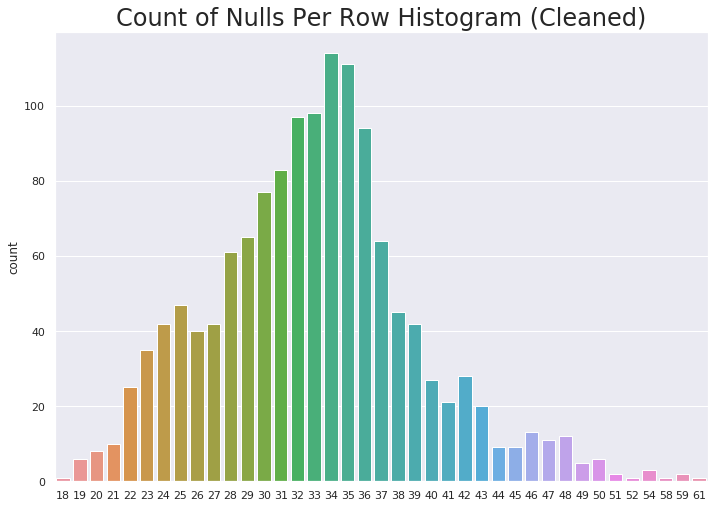

In [172]:
# number of missing values per row

plt.title('Count of Nulls Per Row Histogram (Cleaned)', size=24)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(clean_df.isnull().sum(axis=1)) #, palette="GnBu")

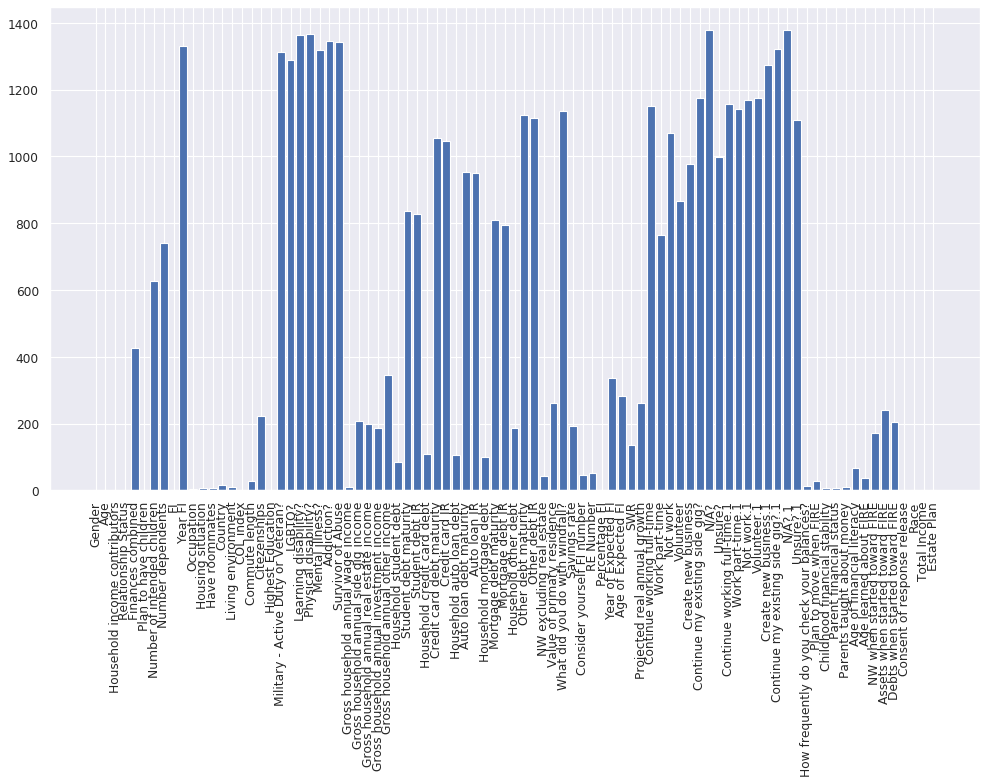

In [164]:
# Histogram of missing values 
x_len = len(clean_df.columns)
y_axis = []
x_axis = []

for col in clean_df.columns:
    null_col = clean_df[col].isnull().sum()
    y_axis.append(null_col)
    x_axis.append(col)


from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

plt.xticks(rotation=90)
plt.bar(x_axis, y_axis)

plt.show()

**The majority of the fields with a high number of missing values have to do with raere characteristics, FI status, and plans after FI/RE

In [208]:
raw_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 148 columns):
Gender                                                     1378 non-null object
Age                                                        1378 non-null object
Household income contributors                              1378 non-null object
Relationship Status                                        1378 non-null object
Finances combined                                          961 non-null object
Plan to have children                                      1376 non-null object
Number of intended children                                766 non-null object
Number dependents                                          646 non-null object
FI                                                         1378 non-null object
Year FI                                                    68 non-null object
Occupation                                                 1374 non-null object
Housing situation

In [209]:
raw_df['What did you do with windfall?'].unique()

array([nan, 'Invested it', 'Debt repayment', 'Saved it',
       'Spent some and invested some', 'Spent it', 'Other', 'Real estate'],
      dtype=object)

In [211]:
# Fill some of the nulls with zeros


# change the Year FI to be FI Yes/No



In [212]:
# Year FI
raw_df['Year FI'].unique()

array([nan, 2012.0, 2016.0, 2015.0, 'Other', 40.0, 2014.0, 2011.0, 2010.0,
       56.0, 46.0, 2013.0, 2004.0, 33.0, 2005.0], dtype=object)

Some people apparently entered their age instead of the year of FI, so if we keep this feature, we can imput the mean. However, there are so many nulls in this field I'm comfortable throwing it out.

In [213]:
raw_df = raw_df.drop('Year FI', axis = 1)

In [214]:
# want to know if nulls in number of dependents is due to zero or actual null
raw_df['Number dependents'].unique()


array([nan, 0.0, 2.0, 'Other', 1.0, 3.0, 4.0], dtype=object)

In [215]:
raw_df['Commute length'].unique()

array(['30-60 minutes', '10-30 minutes', '<10 minutes', nan,
       '60-90 minutes', 'Work at home', '90+ minutes', 'Other'],
      dtype=object)

In [216]:
raw_df['Citezenships'].unique()

array(['United States', nan, 'Other'], dtype=object)

In [217]:
# looking at Citizenships, the nulls were all due to belonging to a different country. Will drop this field.
raw_df = raw_df.drop('Citezenships', axis = 1)

In [218]:
raw_df['American Indian or Alaskan Native?'].value_counts()

Other                                25
American Indian or Alaskan Native    11
Name: American Indian or Alaskan Native?, dtype: int64

In [219]:
raw_df['Asian or Pacific Islander?'].value_counts()

Asian or Pacific Islander    137
Other                         25
Name: Asian or Pacific Islander?, dtype: int64

In [220]:
raw_df['White / Caucasian?'].value_counts()

White / Caucasian    1195
Other                  25
Name: White / Caucasian?, dtype: int64

It appears that there are a lot of 'Other' answers in each response category, which I believe indicates a null value. Therefore, we can specify a function that returns 1 if a value is found that is not 'Other', and zero otherwise

In [221]:
def binarizer():
#takes a dataframe (df) and a feature (field)
# returns 1 if there is a value present in the feature
# else, returns a 0 for a null value
    def main(x):
        product = np.nan
        if x == 'Other':
            product = 0
        elif pd.isnull(x):
            product = 0
        else:
            product = 1
        return product
    return main

In [222]:
# map onto the fields
raw_df['White / Caucasian'] = raw_df['White / Caucasian?'].map(binarizer())

# Inspect the mapping
raw_df [['White / Caucasian', 'White / Caucasian?']]

,White / Caucasian,White / Caucasian?
0,1,White / Caucasian
1,1,White / Caucasian
2,1,White / Caucasian
3,0,NaN
4,1,White / Caucasian
5,1,White / Caucasian
6,1,White / Caucasian
7,1,White / Caucasian
8,1,White / Caucasian
9,0,NaN


In [223]:
# map onto the fields
raw_df['American Indian or Alaskan Native'] = raw_df['American Indian or Alaskan Native?'].map(binarizer())

# Inspect the mapping
raw_df [['American Indian or Alaskan Native', 'American Indian or Alaskan Native?']]

,American Indian or Alaskan Native,American Indian or Alaskan Native?
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN
5,0,NaN
6,0,NaN
7,0,NaN
8,0,NaN
9,0,NaN


In [191]:
# convert the other features in this category
raw_df['Asian or Pacific Islander'] = raw_df['Asian or Pacific Islander?'].map(binarizer())
raw_df['Black or African American'] = raw_df['Black or African American?'].map(binarizer())
raw_df['Hispanic or Latino'] = raw_df['Hispanic or Latino?'].map(binarizer())
raw_df['Prefer not to answer'] = raw_df['Prefer not to answer?'].map(binarizer())
raw_df['Caribbean'] = raw_df['Caribbean?'].map(binarizer())

# drop the old columns
raw_df2 = raw_df.drop(['White / Caucasian?', 'American Indian or Alaskan Native?', 'Asian or Pacific Islander?', 
                     'Black or African American?', 'Hispanic or Latino?', 'Prefer not to answer?', 'Caribbean?',], 
                    axis = 1)

In [192]:
raw_df2['Military - Active Duty or Veteran?'].value_counts()

Military - Active Duty or Veteran    62
Other                                25
Name: Military - Active Duty or Veteran?, dtype: int64

In [193]:
raw_df2['LGBTQ?'].value_counts()

LGBTQ    88
Other    25
Name: LGBTQ?, dtype: int64

In [194]:
raw_df2['Addiction?'].value_counts()

Addiction    30
Other        25
Name: Addiction?, dtype: int64

In [196]:
#rename a field for consistency
raw_df2.rename(columns={'Survivor of Abuse':'Survivor of Abuse?'}, inplace=True)

In [197]:
# these categories look to have nulls that mean the thing is not present, so I will binarize them as well
raw_df2['Military - Active Duty or Veteran'] = raw_df2['Military - Active Duty or Veteran?'].map(binarizer())
raw_df2['LGBTQ'] = raw_df2['LGBTQ?'].map(binarizer())
raw_df2['Learning disability'] = raw_df2['Learning disability?'].map(binarizer())
raw_df2['Physical disability'] = raw_df2['Physical disability?'].map(binarizer())
raw_df2['Mental illness'] = raw_df2['Mental illness?'].map(binarizer())
raw_df2['Addiction'] = raw_df2['Addiction?'].map(binarizer())
raw_df2['Survivor of Abuse'] = raw_df2['Survivor of Abuse?'].map(binarizer())

# drop the old columns
raw_df3 = raw_df2.drop(['Military - Active Duty or Veteran?', 'LGBTQ?', 'Learning disability?', 'Physical disability?'
                     ,'Mental illness?', 'Addiction?', 'Survivor of Abuse?'], axis = 1)


In [224]:
for col in raw_df3.columns:
    print(col)

Gender
Age
Household income contributors
Relationship Status
Finances combined
Plan to have children
Number of intended children
Number dependents
FI
Occupation
Housing situation
Have roommates
Country
Living environment
COL index
Commute length
Highest Education
Gross household annual wage income
Gross household annual side gig income
Gross household annual real estate income
Gross household annual investment income
Gross household annual other income
Household student debt
Student debt maturity
Student debt IR
Household credit card debt
Credit card debt maturity
Credit card IR
Household auto loan debt
Auto loan debt maturity
Auto loan IR
Household mortgage debt
Mortgage debt maturity
Mortgage debt IR
Household other debt
Other debt maturity
Other debt IR
NW excluding real estate
Value of primary residence
Household portfolio allocation
Unnamed: 60
Unnamed: 61
Unnamed: 62
Unnamed: 63
Unnamed: 64
Household's investments allocations across accounts
Unnamed: 66
Unnamed: 67
Unnamed: 68
Un